Ref: [Game of Deep Learning: Ship datasets](https://www.kaggle.com/arpitjain007/game-of-deep-learning-ship-datasets/notebooks)
* [Ship Classification - Top 3.3 % Kernel](https://www.kaggle.com/sandeeppat/ship-classification-top-3-5-kernel)
* [AV-game of deep learning](https://www.kaggle.com/narendrashu/av-game-of-deep-learning)

In [1]:
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import cv2

from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy
import torchvision.models as models

# 1. สำรวจข้อมูล

**1) โครงสร้างไฟล์** 

* ship-balance
    * train
        * 2870024.jpg ...
    * test
        * 2868091.jpg ...
    * train.csv
    * test.csv
    
**2) ข้อมูล train.csv** 

In [2]:
train_df = pd.read_csv('C:/Users/NCC/Desktop/thesis/dataset/ship-balance/train.csv')

In [3]:
category_label = {1: 'Cargo', 2:'Military', 3:'Carrier', 4:'Cruise', 5:'Tankers'}
train_df['label'] = train_df['category'].map(category_label)

In [4]:
train_df.head()

,image,category,label
0,2870024.jpg,1,Cargo
1,2900420.jpg,3,Carrier
2,2804883.jpg,2,Military
3,2859567.jpg,3,Carrier
4,2847618.jpg,3,Carrier


In [5]:
train_df.groupby('category').count()[['image']]

,image
category,
1,500
2,500
3,500
4,500
5,500


<AxesSubplot:xlabel='label', ylabel='count'>

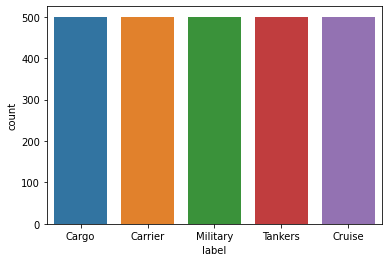

In [6]:
sns.countplot(x='label' , data=train_df)

**3) ข้อมูลรูปภาพใน train** 

In [7]:
# Read images according to train.csv

train_images=[]

for i in range(len(train_df)):
    img = os.path.join("C:/Users/NCC/Desktop/thesis/dataset/ship-balance/train/", train_df.image[i])
    img = cv2.imread(img)
    train_images.append(img)

print("Number of train images =", len(train_images))
print("Shape of an image =", train_images[99].shape)

Number of train images = 2500
Shape of an image = (129, 210, 3)


Categoty: Cargo


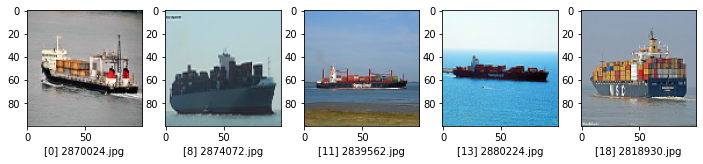

Categoty: Military


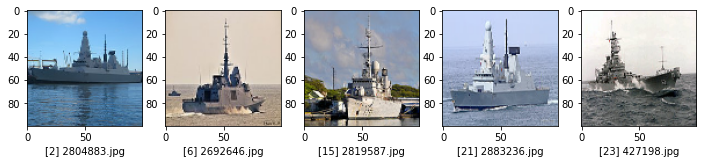

Categoty: Carrier


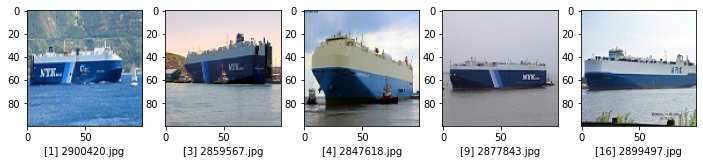

Categoty: Cruise


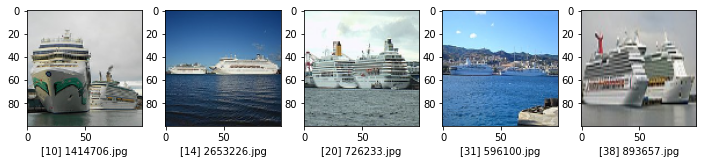

Categoty: Tankers


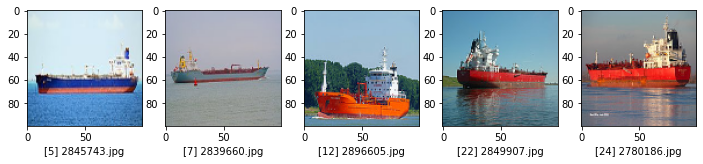

In [8]:
# Show images from each category

for cat in category_label.values():
    fetch = train_df.loc[train_df['label']==cat][:5]
    fig = plt.figure(figsize=(12,7))

    for i , index in enumerate(fetch.index ,1):
        plt.subplot(1,5,i)
        img = train_images[index]
        img = cv2.resize(img, (100, 100))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.xlabel("["+str(index)+"] "+str(fetch.image[index]))
        
    print("Categoty:",cat)
    plt.show()

# 2. เตรียมข้อมูล

In [9]:
path = Path('C:/Users/NCC/Desktop/thesis/dataset/ship-balance')

tfms = aug_transforms(do_flip=True,
                      flip_vert=False,
                      max_rotate=10.0, 
                      max_zoom=1.2, 
                      max_lighting=0.2, 
                      max_warp=0.2, 
                      p_affine=0.2)

dls = ImageDataLoaders.from_csv(path, 
                                 folder='train', 
                                 csv_fname='train.csv',
                                 valid_pct=0.2,
                                 seed=42, 
                                 item_tfms=Resize(128), 
                                 batch_tfms=tfms, 
                                 num_workers=0)

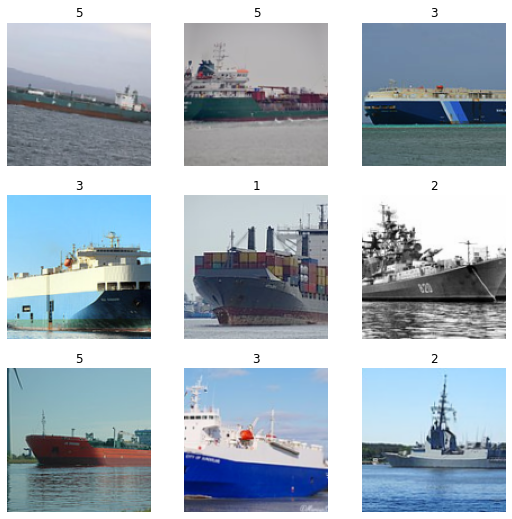

In [10]:
dls.show_batch()

# 3. สร้างโมเดลและเทรน

In [11]:
learn = cnn_learner(dls,
                    resnet18, 
                    normalize=True, 
                    pretrained=True,
                    metrics=[error_rate, accuracy])

SuggestedLRs(lr_min=0.017378008365631102, lr_steep=0.007585775572806597)

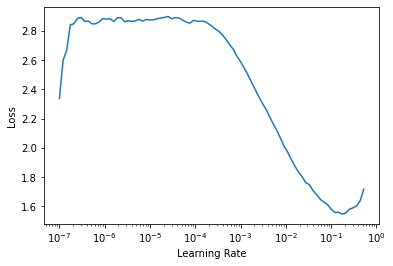

In [12]:
learn.lr_find()

In [13]:
print("Optimizer...")
learn.recorder.opt_func

Optimizer...


<function fastai.optimizer.Adam(params, lr, mom=0.9, sqr_mom=0.99, eps=1e-05, wd=0.01, decouple_wd=True)>

In [14]:
print("Loss Function...")
learn.recorder.loss_func

Loss Function...


FlattenedLoss of CrossEntropyLoss()

In [15]:
lr = 0.02089296132326126
learn.fit_one_cycle(10,lr)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.820670,0.450359,0.086000,0.914000,00:08
1,0.515098,0.697360,0.134000,0.866000,00:08
2,0.442653,0.575978,0.116000,0.884000,00:08
3,0.418688,0.409302,0.074000,0.926000,00:08
4,0.349985,0.552806,0.090000,0.910000,00:08
5,0.297050,0.186623,0.058000,0.942000,00:08
6,0.217396,0.104429,0.034000,0.966000,00:08
7,0.158487,0.078675,0.020000,0.980000,00:08
8,0.122338,0.075221,0.016000,0.984000,00:08
9,0.087459,0.075765,0.020000,0.980000,00:08


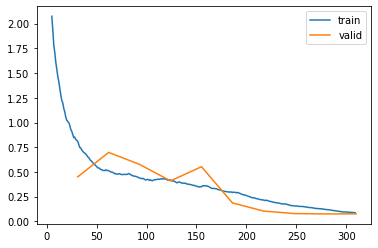

In [16]:
learn.recorder.plot_loss()

In [17]:
interp = ClassificationInterpretation.from_learner(learn)

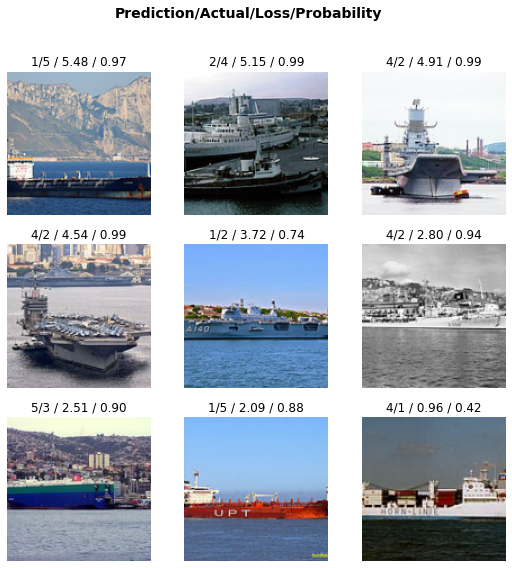

In [18]:
interp.plot_top_losses(9)

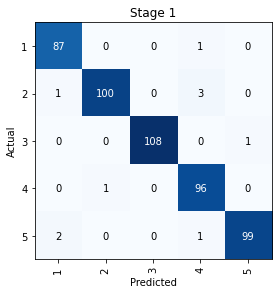

In [19]:
interp.plot_confusion_matrix(title='Stage 1')

In [20]:
interp.print_classification_report()

              precision    recall  f1-score   support

           1       0.97      0.99      0.98        88
           2       0.99      0.96      0.98       104
           3       1.00      0.99      1.00       109
           4       0.95      0.99      0.97        97
           5       0.99      0.97      0.98       102

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



# 4. เทรนอีกรอบแบบ unfreeze

In [21]:
learn.unfreeze()

SuggestedLRs(lr_min=3.311311302240938e-05, lr_steep=7.585775847473997e-07)

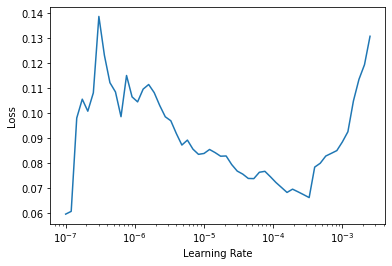

In [22]:
learn.lr_find()

In [23]:
learn.fit_one_cycle(10, lr_max=slice(1e-6, 1e-5))

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,0.060320,0.074804,0.018000,0.982000,00:09
1,0.069065,0.086654,0.026000,0.974000,00:09
2,0.070183,0.075744,0.016000,0.984000,00:09
3,0.059628,0.080113,0.020000,0.980000,00:09
4,0.054937,0.075479,0.018000,0.982000,00:09
5,0.049501,0.075389,0.018000,0.982000,00:09
6,0.053817,0.079435,0.018000,0.982000,00:09
7,0.051698,0.083142,0.022000,0.978000,00:09
8,0.062674,0.076587,0.020000,0.980000,00:09
9,0.059943,0.072509,0.018000,0.982000,00:09


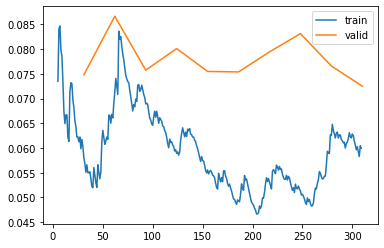

In [24]:
learn.recorder.plot_loss()

In [25]:
interp1 = ClassificationInterpretation.from_learner(learn)

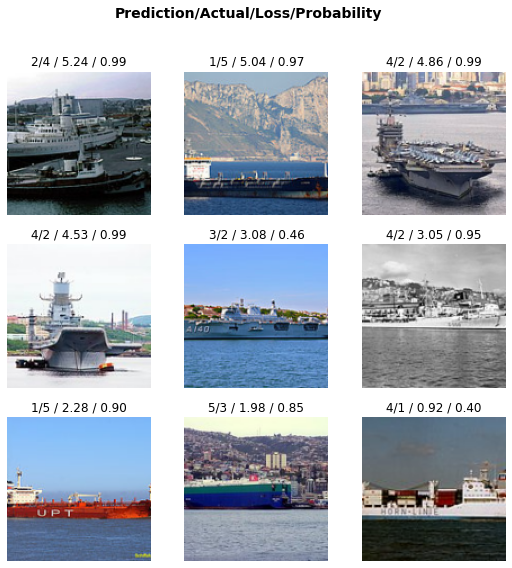

In [26]:
interp1.plot_top_losses(9)

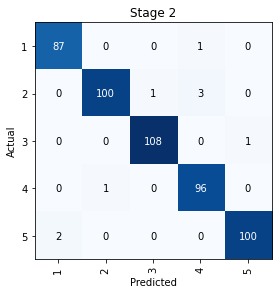

In [27]:
interp1.plot_confusion_matrix(title='Stage 2')

In [28]:
interp1.print_classification_report()

              precision    recall  f1-score   support

           1       0.98      0.99      0.98        88
           2       0.99      0.96      0.98       104
           3       0.99      0.99      0.99       109
           4       0.96      0.99      0.97        97
           5       0.99      0.98      0.99       102

    accuracy                           0.98       500
   macro avg       0.98      0.98      0.98       500
weighted avg       0.98      0.98      0.98       500



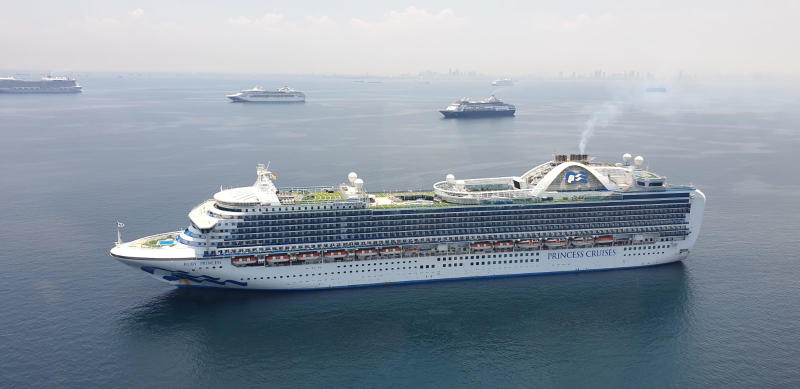

In [29]:
filename = 'C:/Users/NCC/Desktop/cruise.jpg'
img = PILImage.create(filename)
img

In [34]:
pred,_,probs = learn.predict(img)
print(pred)
print(_)
print(probs)

4
tensor(3)
tensor([0.0092, 0.0091, 0.0043, 0.9680, 0.0094])
